In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.transform import resize 
import tensorflow as tf
import itertools

## Load Dataset

In [2]:
datamining_dir = "./"

X_train = np.load(datamining_dir + "train_X.npy")
X_test = np.load(datamining_dir + "test_X.npy")
y_train = np.load(datamining_dir + "train_Y.npy")
y_test = np.load(datamining_dir + "test_Y.npy")

print("X_train shape ", X_train.shape)
print("y_train shape ", y_train.shape)
print("X_test shape ", X_test.shape)
print("y_test shape ", y_test.shape)

X_train shape  (16653, 64, 64)
y_train shape  (16653,)
X_test shape  (4163, 64, 64)
y_test shape  (4163,)


## Display few images

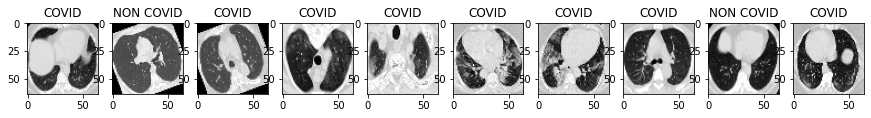

In [3]:
fig, axes = plt.subplots(1,10,figsize=(15,15))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title("COVID" if y_train[i] == 0 else "NON COVID")

## Flattening images for PCA

In [4]:
dims = 64
flatten_X_train = X_train.reshape(X_train.shape[0], dims*dims)
flatten_X_test = X_test.reshape(X_test.shape[0], dims*dims)

print(flatten_X_train.shape)
print(flatten_X_test.shape)

(16653, 4096)
(4163, 4096)


## PCA

In [5]:
pca = PCA(n_components=0.7)

pca.fit(flatten_X_train)

PCA(n_components=0.7)

## Display Eigenimages for PCA

(19, 4096)


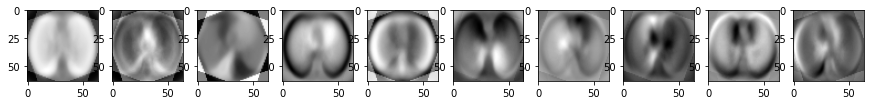

In [6]:
print(pca.components_.shape)
fig, axes = plt.subplots(1,10,figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(dims,dims), cmap="gray")

## Inverse transform images to get reduced train and test set

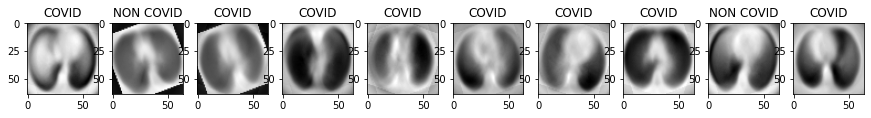

In [7]:
components = pca.transform(flatten_X_train)
X_reduced = pca.inverse_transform(components)
X_train_imgs = X_reduced.reshape(X_train.shape[0], dims, dims)

fig, axes = plt.subplots(1,10,figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_imgs[i], cmap='gray')
    ax.set_title("COVID" if y_train[i] == 0 else "NON COVID")
    
X_train_imgs = np.stack((X_train_imgs, X_train_imgs, X_train_imgs), axis=3)

test_components = pca.transform(flatten_X_test)
X_test_reduced = pca.inverse_transform(test_components)
X_test_imgs = X_test_reduced.reshape(X_test.shape[0], dims, dims)

X_test_imgs = np.stack((X_test_imgs, X_test_imgs, X_test_imgs), axis=3)

## Preparing Model

In [8]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras import optimizers
import keras

resnet = ResNet50(include_top=False, input_shape=(dims, dims, 3))

for layer in resnet.layers:
    layer.trainable = False

In [9]:
dnn = tf.keras.layers.Flatten()(resnet.output)
dnn = tf.keras.layers.Dense(512, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(256, activation='relu')(dnn)
dnn = tf.keras.layers.Dense(1, activation='sigmoid')(dnn)

model = Model(resnet.input, dnn)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 27,979,905
Trainable params: 4,392,193
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None


## Training

In [10]:
hist = model.fit(X_train_imgs, y_train, validation_split=0.2, epochs=10, steps_per_epoch = 100)

Epoch 1/10
100/100 [==============================] - 121s 1s/step - loss: 0.7856 - acc: 0.6250 - val_loss: 0.6057 - val_acc: 0.6917
Epoch 2/10
100/100 [==============================] - 105s 1s/step - loss: 0.5366 - acc: 0.7258 - val_loss: 0.4978 - val_acc: 0.7583
Epoch 3/10
100/100 [==============================] - 104s 1s/step - loss: 0.4888 - acc: 0.7603 - val_loss: 0.5349 - val_acc: 0.7283
Epoch 4/10
100/100 [==============================] - 105s 1s/step - loss: 0.4508 - acc: 0.7819 - val_loss: 0.4765 - val_acc: 0.7736
Epoch 5/10
100/100 [==============================] - 107s 1s/step - loss: 0.4092 - acc: 0.8110 - val_loss: 0.5124 - val_acc: 0.7514
Epoch 6/10
100/100 [==============================] - 107s 1s/step - loss: 0.3915 - acc: 0.8183 - val_loss: 0.4357 - val_acc: 0.7968
Epoch 7/10
100/100 [==============================] - 109s 1s/step - loss: 0.3500 - acc: 0.8443 - val_loss: 0.4351 - val_acc: 0.7953
Epoch 8/10
100/100 [==============================] - 108s 1s/step - 

## Evaluating

In [11]:
model.evaluate(X_test_imgs, y_test)
y_pred = model.predict(X_test_imgs)

131/131 [==============================] - 31s 236ms/step - loss: 0.4773 - acc: 0.7826


## Plotting Loss

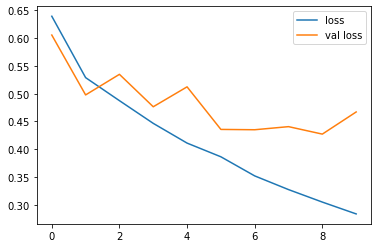

In [12]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()

## Plotting Accuracy

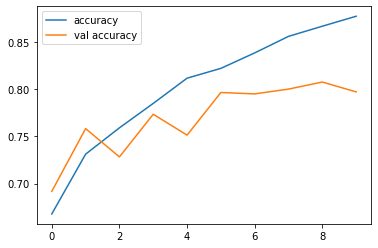

In [13]:
plt.plot(hist.history['acc'], label='accuracy')
plt.plot(hist.history['val_acc'], label='val accuracy')
plt.legend()

In [14]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Confusion Matrix

Confusion matrix, without normalization
[[1507  331]
 [ 574 1751]]


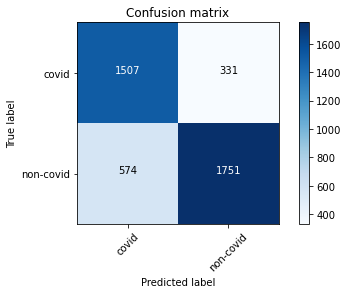

In [15]:
y_pred = np.around(y_pred.reshape(y_test.shape))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['covid', 'non-covid'],
                      title='Confusion matrix')

## Fscore, Precision, Recall

In [16]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)
print("Precision of (covid, non-covid): ", precision)
print("Recall of (covid, non-covid): ", recall)
print("Fscore of (covid, non-covid): ", fscore)

Precision of (covid, non-covid):  [0.72417107 0.84101825]
Recall of (covid, non-covid):  [0.81991295 0.75311828]
Fscore of (covid, non-covid):  [0.76907374 0.79464488]
